# Explore data and add missing timestamp

The train and test data have missing timestamps. In this notebook, I add the missing timestamps in both train and test. In order to create lag and moving avergae features, I also added mock demand data for test, which is 1.02 times the demand for last year

In [1]:
%config Completer.use_jedi = False

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import datetime

In [3]:
# read in data

train = pd.read_csv('../data/input/train_E1GspfA.csv', parse_dates=['date'])
test = pd.read_csv('../data/input/test_6QvDdzb.csv', parse_dates=['date'])
sample = pd.read_csv('../data/input/sample_4E0BhPN.csv', parse_dates=['date'])

# Train

In [4]:
train.shape

(18247, 3)

In [5]:
# set datetime as index

train.set_index(pd.to_datetime(train.date) + pd.to_timedelta(train.hour, unit='h'), inplace=True)

In [6]:
train.index

DatetimeIndex(['2018-08-18 09:00:00', '2018-08-18 10:00:00',
               '2018-08-18 13:00:00', '2018-08-18 14:00:00',
               '2018-08-18 15:00:00', '2018-08-18 16:00:00',
               '2018-08-18 17:00:00', '2018-08-18 18:00:00',
               '2018-08-18 19:00:00', '2018-08-18 20:00:00',
               ...
               '2021-02-28 14:00:00', '2021-02-28 15:00:00',
               '2021-02-28 16:00:00', '2021-02-28 17:00:00',
               '2021-02-28 18:00:00', '2021-02-28 19:00:00',
               '2021-02-28 20:00:00', '2021-02-28 21:00:00',
               '2021-02-28 22:00:00', '2021-02-28 23:00:00'],
              dtype='datetime64[ns]', length=18247, freq=None)

In [7]:
train.head()

,date,hour,demand
2018-08-18 09:00:00,2018-08-18,9,91
2018-08-18 10:00:00,2018-08-18,10,21
2018-08-18 13:00:00,2018-08-18,13,23
2018-08-18 14:00:00,2018-08-18,14,104
2018-08-18 15:00:00,2018-08-18,15,81


In [8]:
train.isna().sum()

date      0
hour      0
demand    0
dtype: int64

In [9]:
train.dtypes

date      datetime64[ns]
hour               int64
demand             int64
dtype: object

In [10]:
train.index.min()

Timestamp('2018-08-18 09:00:00')

In [11]:
train.index.max()

Timestamp('2021-02-28 23:00:00')

In [12]:
# check if timestamp is available for all dates in the date range

pd.date_range(start= train.index.min().date(), end=train.index.max().date(), freq='1H').difference(train.index)

DatetimeIndex(['2018-08-18 00:00:00', '2018-08-18 01:00:00',
               '2018-08-18 02:00:00', '2018-08-18 03:00:00',
               '2018-08-18 04:00:00', '2018-08-18 05:00:00',
               '2018-08-18 06:00:00', '2018-08-18 07:00:00',
               '2018-08-18 08:00:00', '2018-08-18 11:00:00',
               ...
               '2021-02-22 05:00:00', '2021-02-23 01:00:00',
               '2021-02-23 03:00:00', '2021-02-23 05:00:00',
               '2021-02-24 02:00:00', '2021-02-24 03:00:00',
               '2021-02-24 05:00:00', '2021-02-25 01:00:00',
               '2021-02-25 03:00:00', '2021-02-25 05:00:00'],
              dtype='datetime64[ns]', length=3977, freq=None)

In [123]:
# full date range

dates_range = pd.date_range(start=train.index.min(), end=train.index.max(), freq='1H')
df_dates_range = pd.DataFrame(data = dates_range, columns= ['datetime']).set_index(['datetime'])

In [124]:
# fill in missing datestamps

train_missing_timestamp_filled = df_dates_range.join(train)

In [125]:
train_missing_timestamp_filled

,date,hour,demand
datetime,,,
2018-08-18 09:00:00,2018-08-18,9.0,91.0
2018-08-18 10:00:00,2018-08-18,10.0,21.0
2018-08-18 11:00:00,NaT,NaN,NaN
2018-08-18 12:00:00,NaT,NaN,NaN
2018-08-18 13:00:00,2018-08-18,13.0,23.0
...,...,...,...
2021-02-28 19:00:00,2021-02-28,19.0,95.0
2021-02-28 20:00:00,2021-02-28,20.0,88.0
2021-02-28 21:00:00,2021-02-28,21.0,39.0


In [126]:
# fill date

train_missing_timestamp_filled['date'] = train_missing_timestamp_filled.index.date

In [127]:
# fill hour 

train_missing_timestamp_filled['hour'] = train_missing_timestamp_filled.index.hour

In [18]:
train_missing_timestamp_filled

,date,hour,demand
datetime,,,
2018-08-18 00:00:00,2018-08-18,0,NaN
2018-08-18 01:00:00,2018-08-18,1,NaN
2018-08-18 02:00:00,2018-08-18,2,NaN
2018-08-18 03:00:00,2018-08-18,3,NaN
2018-08-18 04:00:00,2018-08-18,4,NaN
...,...,...,...
2021-02-28 19:00:00,2021-02-28,19,95.0
2021-02-28 20:00:00,2021-02-28,20,88.0
2021-02-28 21:00:00,2021-02-28,21,39.0


In [128]:
train_missing_timestamp_filled.isna().sum()

date         0
hour         0
demand    3968
dtype: int64

In [129]:
# For all dates with atleast one non-null value, fill other na with 0. 
# meaning, empty timestamps had no demand

train_missing_timestamp_filled_na_zero = train_missing_timestamp_filled.groupby(['date']).filter(lambda grp: grp['demand'].notnull().values.any()).fillna(0)

In [130]:
# merge with train_missing_timestamp_filled

train_missing_timestamp_filled_1 = train_missing_timestamp_filled.\
merge(train_missing_timestamp_filled_na_zero[['demand']],left_index=True, right_index=True, how='left')

# drop 'demand_x' and rename 'demand_y' as 'demand'

train_missing_timestamp_filled_1 = train_missing_timestamp_filled_1.drop(columns = ['demand_x']).rename(columns = {'demand_y':'demand'})

In [131]:
train_missing_timestamp_filled_1.isna().sum()

date        0
hour        0
demand    744
dtype: int64

In [132]:
# fill nov-dec 2020 with 2019 nov-dec demand * 1.03

fill_missing_values =  train_missing_timestamp_filled_1.loc['2019-11-27':'2019-12-26'].fillna(0).demand.values * 1.03

In [133]:
train_missing_timestamp_filled_1.loc['2020-11-27':'2020-12-26', 'demand'] = fill_missing_values

In [134]:
train_missing_timestamp_filled_1.isnull().sum()

date       0
hour       0
demand    24
dtype: int64

In [135]:
# fill april 2019 with last one week average demand

missing_april_2019 = train_missing_timestamp_filled_1.loc['2019-04-21':'2019-04-27'][['demand','hour']].groupby(['hour']).mean().values

In [136]:
# fill in april 2019

train_missing_timestamp_filled_1.loc['2019-04-28','demand'] = missing_april_2019

In [137]:
# check null

train_missing_timestamp_filled_1.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

# Complete train data

In [139]:
# save to csv

# train_missing_timestamp_filled_1.to_csv('../data/input/train_with_missing_timestamps.csv', index=None)

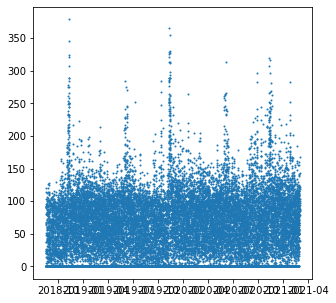

In [140]:
# plot

fig = plt.subplots(1,1, figsize = (5,5))
plt.scatter(train_missing_timestamp_filled_1.index,train_missing_timestamp_filled_1.demand, s=1)
plt.show()

In [39]:
# target

y_train = train_missing_timestamp_filled_1['demand'].copy()

In [40]:
# features

X_train = train_missing_timestamp_filled_1.drop(columns = ['demand']).copy()

# Lag feature

In [41]:
# create lag features

def lag(df, lag_val=1):
    
    df[f'lag_{lag_val}'] = df['demand'].shift(lag_val)

In [43]:
# lag features
# create lag features from lag_1 to lag_7

df = train_missing_timestamp_filled_1.copy()

for i in range(1,8):
    lag(df, i)


df.fillna(0,inplace=True)


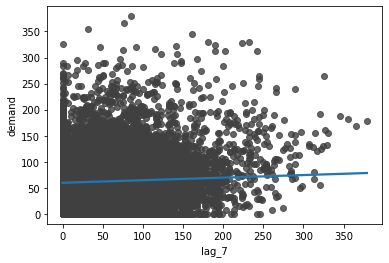

In [52]:
# Lag plot

sns.regplot(x='lag_7', y='demand', data=df, ci=None, scatter_kws=dict(color='0.25'))
plt.show()

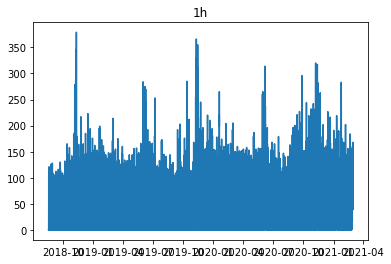

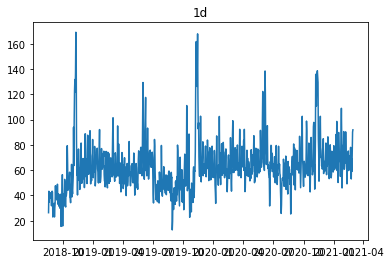

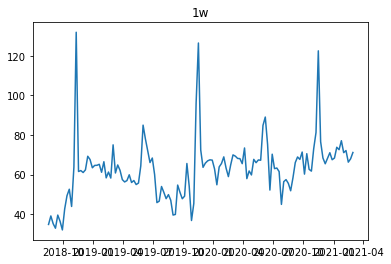

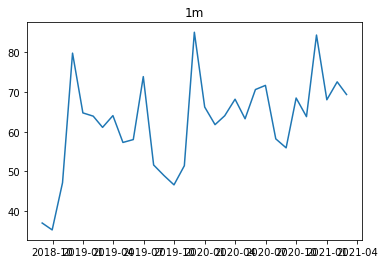

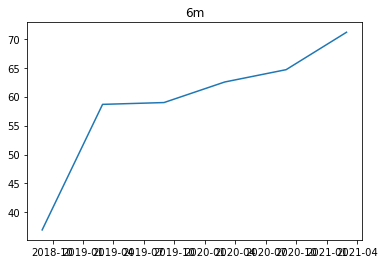

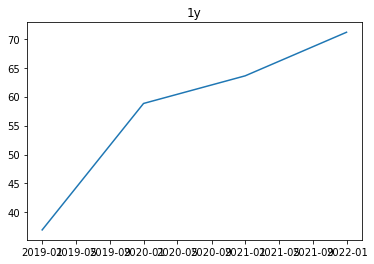

In [59]:
# trend

df = train_missing_timestamp_filled_1.copy()
for i in ['1h', '1d', '1w', '1m', '6m', '1y']:
    
    df = df.resample(i).mean()
    
    plt.plot(df.index, df.demand)
    plt.title(i)
    plt.show()

In [1346]:
mean_2018 = train_missing_timestamp_filled.loc['2018']['demand'].mean()

In [1347]:
mean_2019 = train_missing_timestamp_filled.loc['2019']['demand'].mean()

In [1348]:
mean_2020 = train_missing_timestamp_filled.loc['2020']['demand'].mean()

In [1349]:
mean_2021 = train_missing_timestamp_filled.loc['2021']['demand'].mean()

In [1351]:
mean_2019/mean_2018

1.0224119486509575

In [1352]:
mean_2020/mean_2019

1.0330579792220074

In [1353]:
mean_2021/mean_2020

1.0271388173850626

In [1354]:
growth_rate = 1.03

# Target transformation

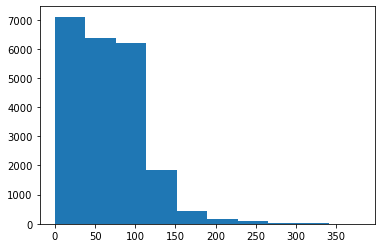

In [60]:
# target

plt.hist(train_missing_timestamp_filled_1['demand'], bins =10)
plt.show()

In [63]:
# log transform target

log_target = np.log1p(y_train)

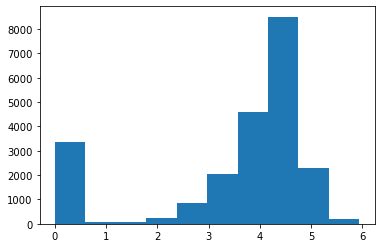

In [64]:
# log target

plt.hist(log_target, bins =10)
plt.show()

# Test

In [65]:
test.shape

(7650, 2)

In [67]:
test.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


In [68]:
# set datetime as index

test.set_index(pd.to_datetime(test.date) + pd.to_timedelta(test.hour, unit='h'), inplace=True)

In [69]:
test.index.min()

Timestamp('2021-03-01 00:00:00')

In [70]:
test.index.max()

Timestamp('2022-03-28 23:00:00')

In [71]:
# check if data is available for all dates in the date range

pd.date_range(start=test.index.min().date(), end=test.index.max()).difference(test.index) 

DatetimeIndex(['2021-03-21', '2021-03-31', '2021-04-07', '2021-04-08',
               '2021-04-19', '2021-04-29', '2021-05-04', '2021-05-17',
               '2021-06-22', '2021-07-29', '2021-07-30', '2021-07-31',
               '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08',
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-31', '2021-09-01', '2021-09-03', '2021-09-06',
               '2021-09-07', '2021-09-13', '2021-09-15', '2021-09-20',
               '2021-09-23', '2021-09-27', '2021-09-28', '2021-09-30',
               '2021-10-04', '2021-10-05', '2021-10-09', '2021-10-13',
      

In [72]:
# full date range

dates_range = pd.date_range(start= test.index.min().date(), end= test.index.max(), freq='1H')
df_dates_range = pd.DataFrame(data = dates_range, columns= ['datetime']).set_index(['datetime'])

In [73]:
# fill in missing datestamps

test_missing_timestamp_filled = df_dates_range.join(test)

In [74]:
# fill date

test_missing_timestamp_filled['date'] = test_missing_timestamp_filled.index.date

In [75]:
# fill hour 

test_missing_timestamp_filled['hour'] = test_missing_timestamp_filled.index.hour

# Add mock demand to test date

In [76]:
# 2021 demand

date_range_2021 = pd.date_range(start='2021-01-01', end='2021-12-31 23:00:00', freq='1H')

In [78]:
df_date_range_2021 = pd.DataFrame(data = date_range_2021, columns= ['datetime']).set_index(['datetime'])

In [80]:
# convert datetime to day, month, year

def convert_datetime_to_day_month_year(df):
    
    date_col = df.index
    
    df.loc[:,'day'] = date_col.day
    df.loc[:,'month'] = date_col.month
    df.loc[:,'year'] = date_col.year
    
    return df
    

In [85]:
# add day, month, year

# train
convert_datetime_to_day_month_year(train_missing_timestamp_filled_1)

# test
convert_datetime_to_day_month_year(df_date_range_2021)



,day,month,year,hour
datetime,,,,
2021-01-01 00:00:00,1,1,2021,0
2021-01-01 01:00:00,1,1,2021,1
2021-01-01 02:00:00,1,1,2021,2
2021-01-01 03:00:00,1,1,2021,3
2021-01-01 04:00:00,1,1,2021,4
...,...,...,...,...
2021-12-31 19:00:00,31,12,2021,19
2021-12-31 20:00:00,31,12,2021,20
2021-12-31 21:00:00,31,12,2021,21


In [82]:
# add hour

df_date_range_2021.loc[:,'hour'] = df_date_range_2021.index.hour

In [86]:
df_date_range_2021_demand = df_date_range_2021.merge(train_missing_timestamp_filled_1.\
                                                     loc['2020'][['day','month','hour','demand']], \
                                                     on = ['day','month','hour'], how = 'inner')

In [88]:
# year-over-year average demand ratio
growth_rate = 1.03

df_date_range_2021_demand['demand'] = (df_date_range_2021_demand['demand']*growth_rate).astype(int)

In [89]:
df_date_range_2021_demand

,day,month,year,hour,demand
0,1,1,2021,0,47
1,1,1,2021,1,42
2,1,1,2021,2,0
3,1,1,2021,3,32
4,1,1,2021,4,0
...,...,...,...,...,...
8755,31,12,2021,19,130
8756,31,12,2021,20,43
8757,31,12,2021,21,107
8758,31,12,2021,22,24


In [90]:
# 2022 demand

date_range_2022 = pd.date_range(start='2022-01-01', end='2022-03-28 23:00:00', freq='1H')

In [91]:
df_date_range_2022 = pd.DataFrame(data = date_range_2022, columns= ['datetime']).set_index(['datetime'])

In [92]:
# add day, month, year

convert_datetime_to_day_month_year(df_date_range_2022)

,day,month,year
datetime,,,
2022-01-01 00:00:00,1,1,2022
2022-01-01 01:00:00,1,1,2022
2022-01-01 02:00:00,1,1,2022
2022-01-01 03:00:00,1,1,2022
2022-01-01 04:00:00,1,1,2022
...,...,...,...
2022-03-28 19:00:00,28,3,2022
2022-03-28 20:00:00,28,3,2022
2022-03-28 21:00:00,28,3,2022


In [93]:
# add hour

df_date_range_2022.loc[:,'hour'] = df_date_range_2022.index.hour

In [94]:
df_date_range_2022_demand = df_date_range_2022.merge(df_date_range_2021_demand[['day','month','hour','demand']], \
                                                     on = ['day','month','hour'], how = 'inner')

In [95]:
df_date_range_2022_demand

,day,month,year,hour,demand
0,1,1,2022,0,47
1,1,1,2022,1,42
2,1,1,2022,2,0
3,1,1,2022,3,32
4,1,1,2022,4,0
...,...,...,...,...,...
2083,28,3,2022,19,119
2084,28,3,2022,20,145
2085,28,3,2022,21,103
2086,28,3,2022,22,22


In [96]:
df_date_range_2022_demand['demand'] = (df_date_range_2022_demand['demand']*growth_rate).astype(int)

In [97]:
# concat both df_date_range_2021_demand and df_date_range_2022_demand

demand_2021_22 = pd.concat([df_date_range_2021_demand, df_date_range_2022_demand])

In [98]:
demand_2021_22['date'] = demand_2021_22['year'].astype(str)+'-'+\
(demand_2021_22['month']).astype(str)+'-'+(demand_2021_22['day']).astype(str)

In [99]:
demand_2021_22['date'] = pd.to_datetime(demand_2021_22['date'])

In [100]:
demand_2021_22

,day,month,year,hour,demand,date
0,1,1,2021,0,47,2021-01-01
1,1,1,2021,1,42,2021-01-01
2,1,1,2021,2,0,2021-01-01
3,1,1,2021,3,32,2021-01-01
4,1,1,2021,4,0,2021-01-01
...,...,...,...,...,...,...
2083,28,3,2022,19,122,2022-03-28
2084,28,3,2022,20,149,2022-03-28
2085,28,3,2022,21,106,2022-03-28
2086,28,3,2022,22,22,2022-03-28


In [119]:
# crop demand_2021_22 to '2021-03 ' to '2022-03'

demand_2021_22_cropped = demand_2021_22[(demand_2021_22['year']!=2021) | (demand_2021_22['month']>=3)]

In [122]:
# save test_with_missing_timestamp
# demand_2021_22_cropped.to_csv('../data/input/test_with_missing_timestamps.csv', index=None)

In [101]:
# merge with sample

sample = sample[['date','hour']].merge(demand_2021_22[['date','hour','demand']], \
                                       on = ['date','hour'], how='inner').drop_duplicates()

In [102]:
sample

,date,hour,demand
0,2021-03-01,0,95
1,2021-03-01,1,66
2,2021-03-01,2,60
3,2021-03-01,3,0
4,2021-03-01,5,72
...,...,...,...
7645,2022-03-28,19,122
7646,2022-03-28,20,149
7647,2022-03-28,21,106
7648,2022-03-28,22,22


In [104]:
# save to csv

sample.to_csv('../data/input/test_with_mock_demand.csv', index=None)